In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import transforms
from torchinfo import summary
import numpy as np
import gym
import os

from models import MDRNNCell, Dense, Controller
from models.mdrnn import loss_fn

In [2]:
dir_path = './results/'
files = os.listdir(dir_path)
files = [f for f in files if 'best_1_1_G' in f]

num = -1
idx = 0
file = ''
for idx, fi in enumerate(files):
    Gnum = fi.split('G')[1].split('.')[0]
    Gnum = int(Gnum)
    if Gnum > num:
        file = fi
        num = Gnum
        
file_path = dir_path + file
s = torch.load(file_path)

In [3]:
file

'best_1_1_G574.p'

In [3]:
ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE = 3, 32, 256, 64, 64

dense = Dense(3, LSIZE, 1024) # Dense：3チャンネル、潜在ベクトルサイズ、中間層サイズ
mdrnn = MDRNNCell(LSIZE, ASIZE, RSIZE, 5) # MDRNN：潜在ベクトルサイズ、アクションサイズ、中間層サイズ、混合ガウス分布の分布数
controller = Controller(LSIZE, RSIZE, ASIZE) # コントローラー：潜在ベクトルサイズ、中間層サイズ、アクションサイズ

dense.load_state_dict(s['dense'])
mdrnn.load_state_dict(s['mdrnn'])
controller.load_state_dict(s['controller'])

<All keys matched successfully>

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor()
])

In [12]:
i = 0
early_termination = True
time_limit = 2000
imgs = []
batches = []

def get_action_and_transition(obs, hidden):
        """ 行動を起こし、遷移

        VAEを用いて観測値を潜在状態に変換し、MDRNNを用いて次の潜在状態と次の隠れ状態の推定を行い、コントローラに対応するアクションを計算する。

        :args obs: current observation (1 x 3 x 64 x 64) torch tensor
        :args hidden: current hidden state (1 x 256) torch tensor

        :returns: (action, next_hidden)
            - action: 1D np array
            - next_hidden (1 x 256) torch tensor
        """
        latent_mu = dense(obs)
        action = controller(latent_mu, hidden[0] ) # コントローラーによるアクションの計算

        mus, sigmas, logpi, rs, d, next_hidden = mdrnn(action, latent_mu, hidden) # MDRNNによる次の潜在状態と次の隠れ状態の推定

        return action.squeeze().cpu().numpy(), next_hidden


with torch.no_grad():       
    env = gym.make('CarRacing-v2', render_mode='rgb_array', domain_randomize=False) # 環境：CarRacing-v2

    obs, _ = env.reset() # 環境のリセット
    imgs.append(obs) # 画像の取得

    hidden = [
        torch.zeros(1, RSIZE)#.to(device) # 隠れ状態の初期化
        for _ in range(2)]

    neg_count = 0 # 負の報酬を受け取った回数

    cumulative = 0 # 累積報酬
    i = 0
    while True:
        obs = transform(obs).unsqueeze(0)#.to(device) # 観測（画像）の前処理：obs(1, 3, 64, 64)
        
        action, hidden = get_action_and_transition(obs, hidden) # 行動を起こし、遷移：action(1, ASIZE), hidden(1, RSIZE)
        #Steering: Real valued in [-1, 1] 
        #Gas: Real valued in [0, 1]
        #Break: Real valued in [0, 1]

        obs, reward, done, _, _ = env.step(action) # 行動を実行し、報酬を受け取る：obs(3, 64, 64), reward, done, info
        imgs.append(obs) # 画像の取得
        
        #報酬を得られなかった（コース外に出たなど）連続回数をカウント
        neg_count = neg_count+1 if reward < 0.0 else 0 
        
        #トレーニングのスピードアップのために、コース外の評価を行い，20time step以上コース外に出た場合はロールアウトを終了する
        if (neg_count>20 and early_termination):  
            done = True
        
        cumulative += reward # 累積報酬の更新
        
        # ロールアウトの終了：タイムリミットに達した場合、早期終了した場合, 完了した場合
        if done or (early_termination and i > time_limit):
            env.close()
            break

        i += 1

# imgs = np.array(imgs)

In [13]:
cumulative

901.499999999985

In [13]:
# imgsから潜在ベクトルを取得
latents = []
with torch.no_grad():
    for img in imgs:
        img = transform(img).unsqueeze(0)#.to(device)
        latent = dense(img)
        latents.append(latent.squeeze().cpu().numpy())

latents = np.array(latents)
latents.shape

(1003, 32)

c:\Users\daiki\miniconda3\envs\env_torch_world_models\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


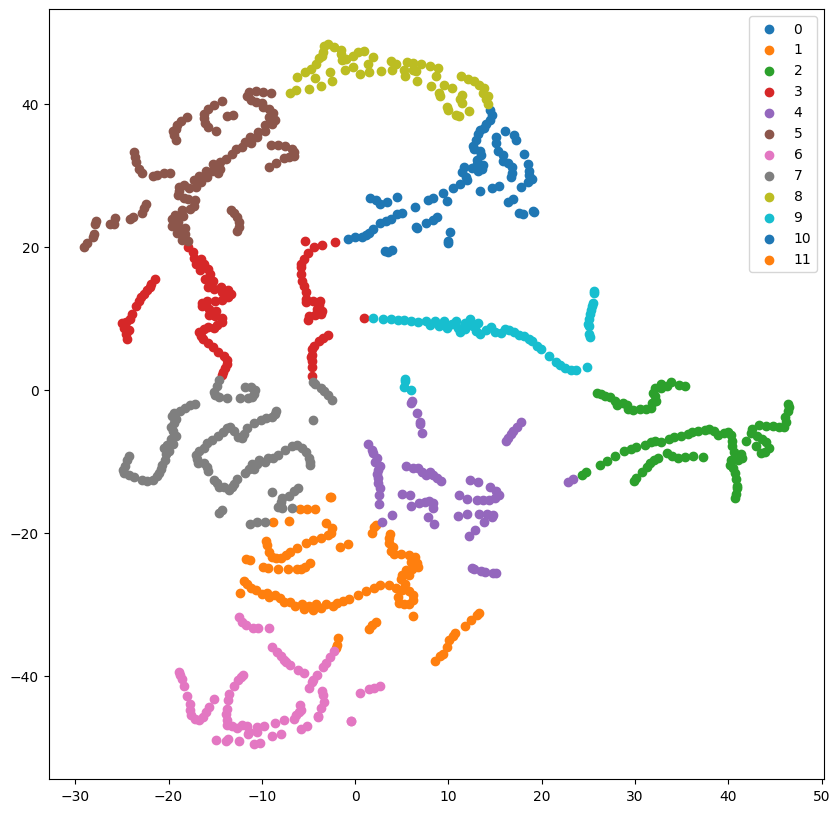

In [9]:
# t-SNEでlatentを2次元に圧縮
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne.fit(latents)

# クラスタリング：k-means，tsneの値を
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(tsne.embedding_)

# latentの可視化
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# クラスごとに色を変えてプロット
for i in range(12):
    plt.scatter(tsne.embedding_[kmeans.labels_==i, 0], tsne.embedding_[kmeans.labels_==i, 1], label=i)
plt.legend()
plt.show()

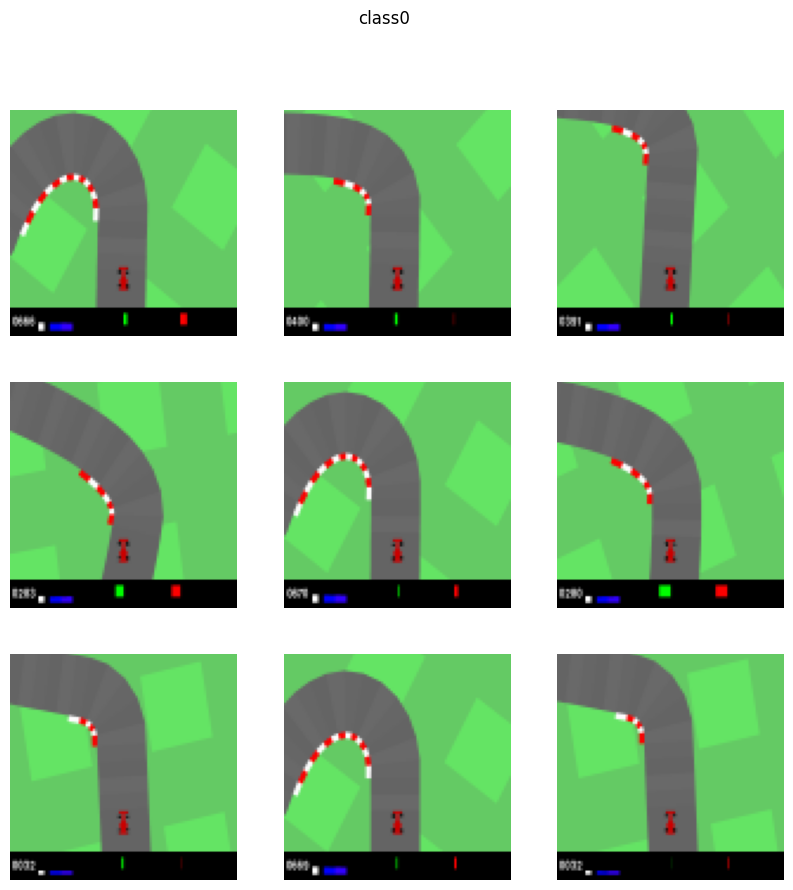

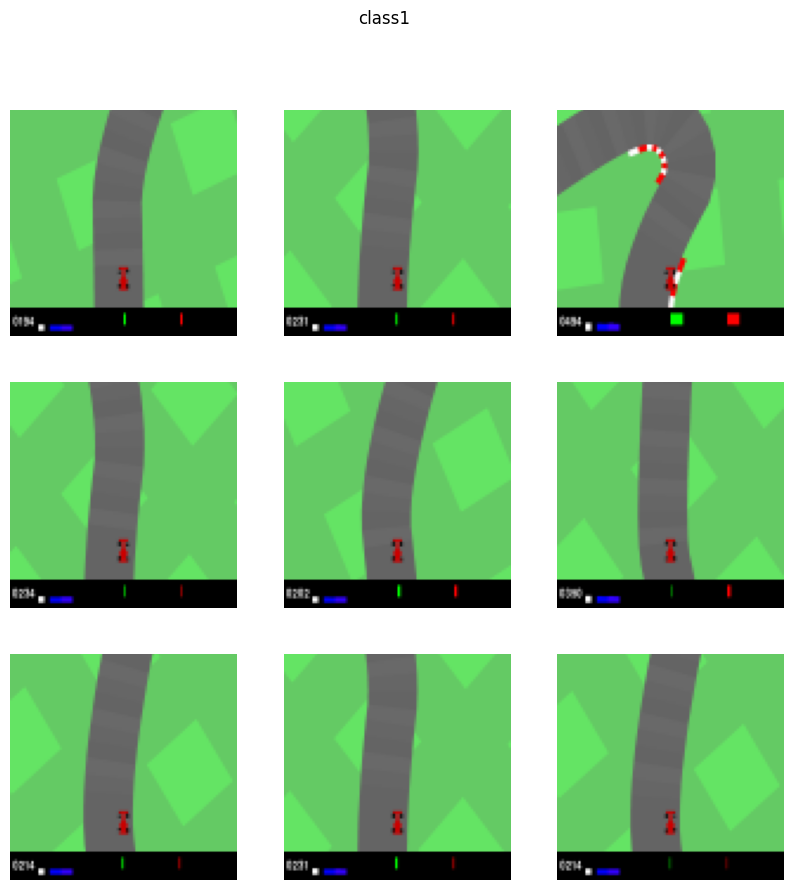

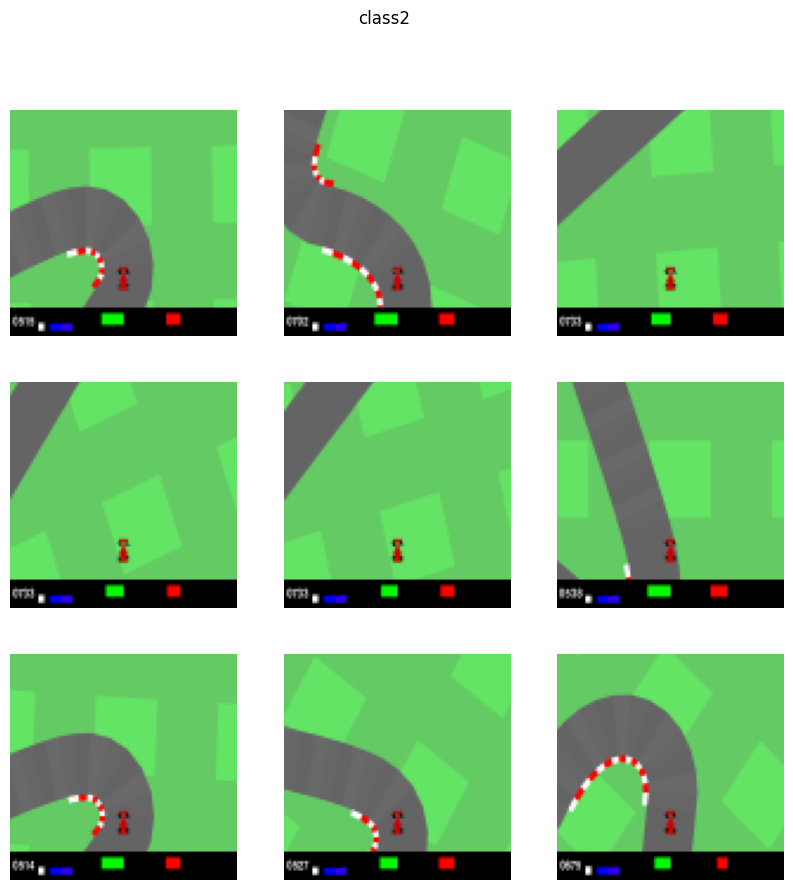

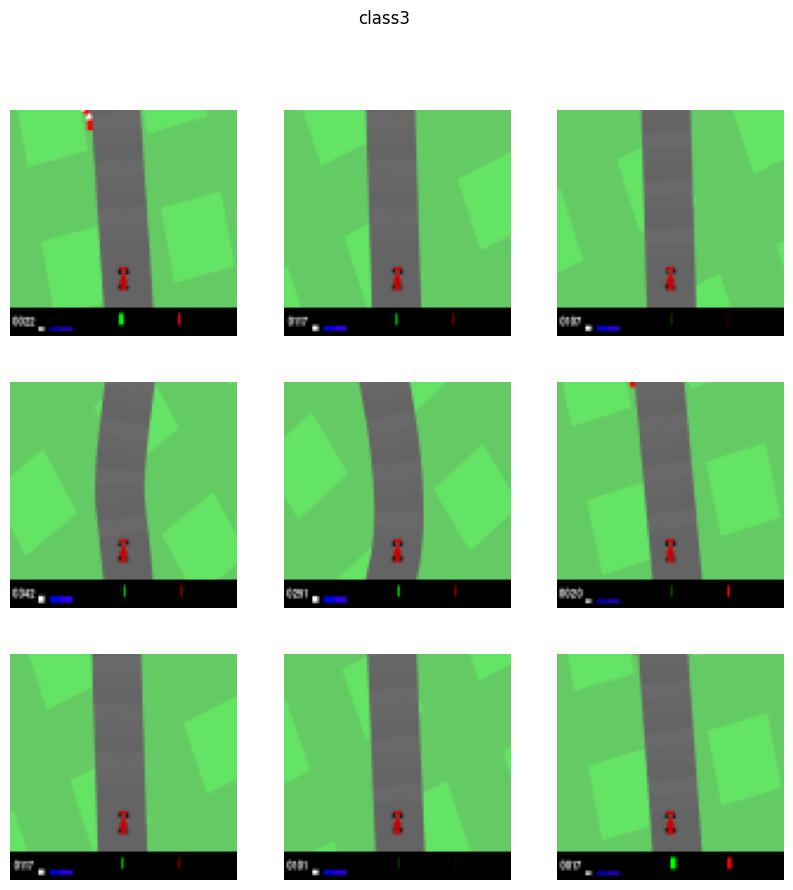

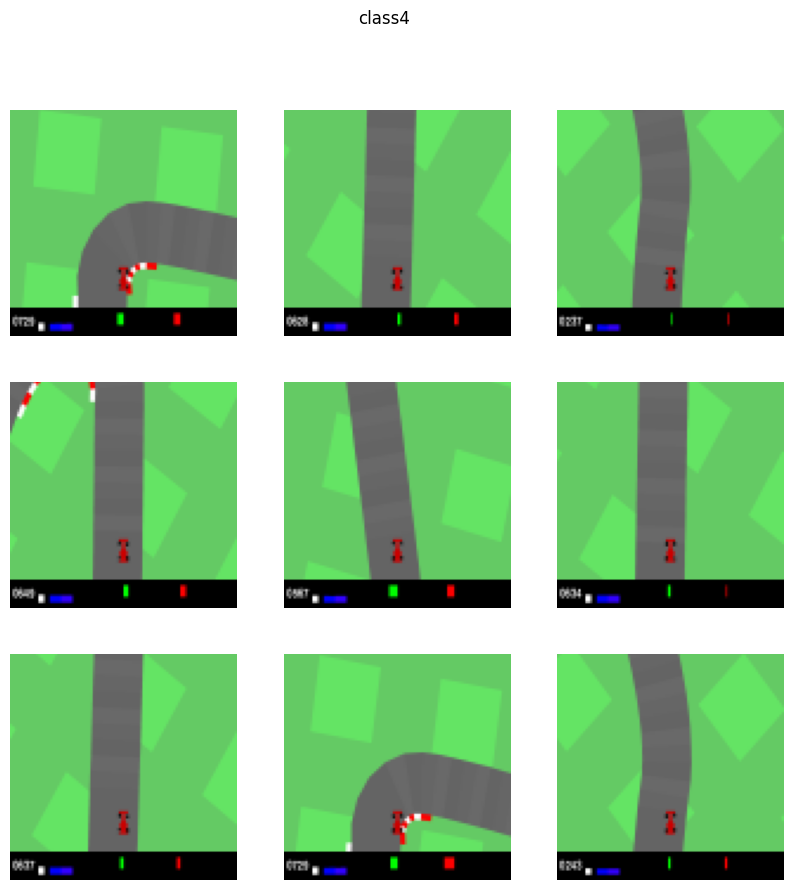

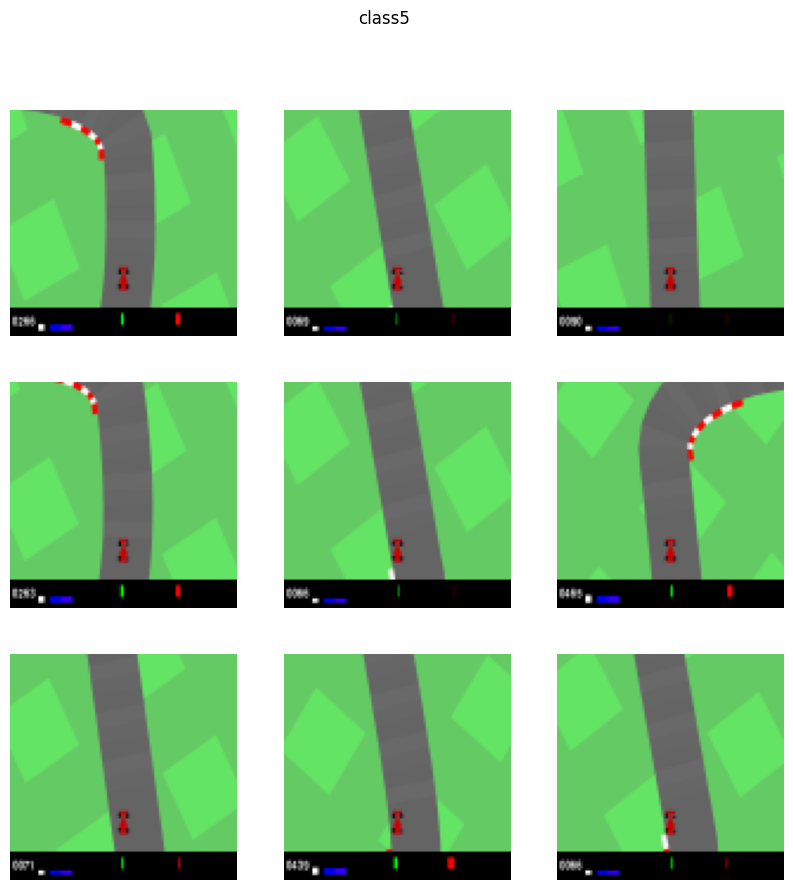

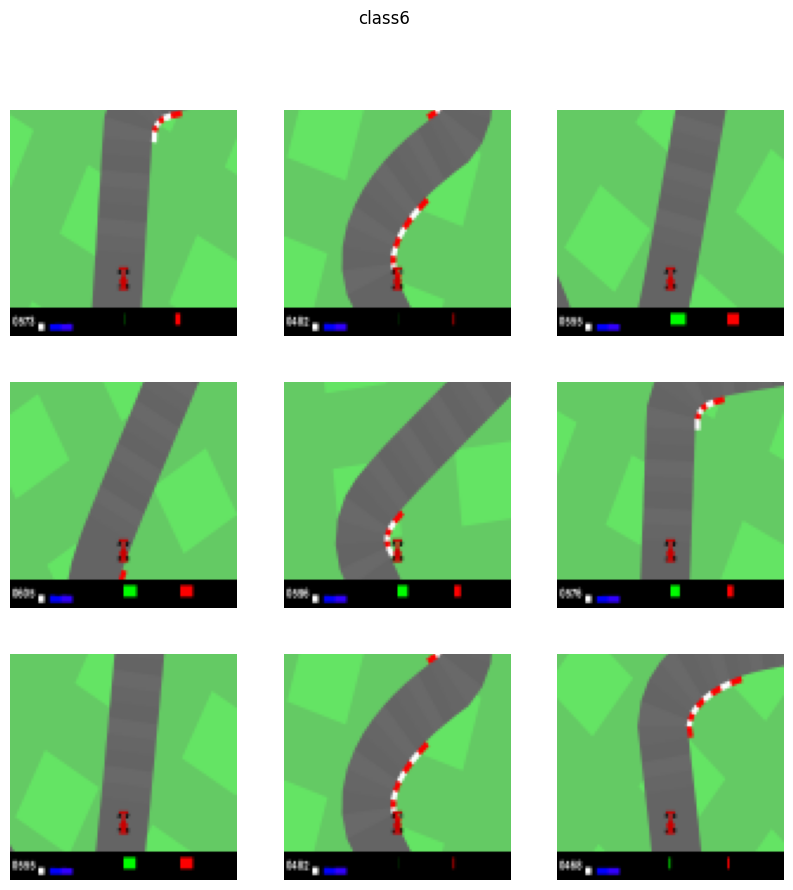

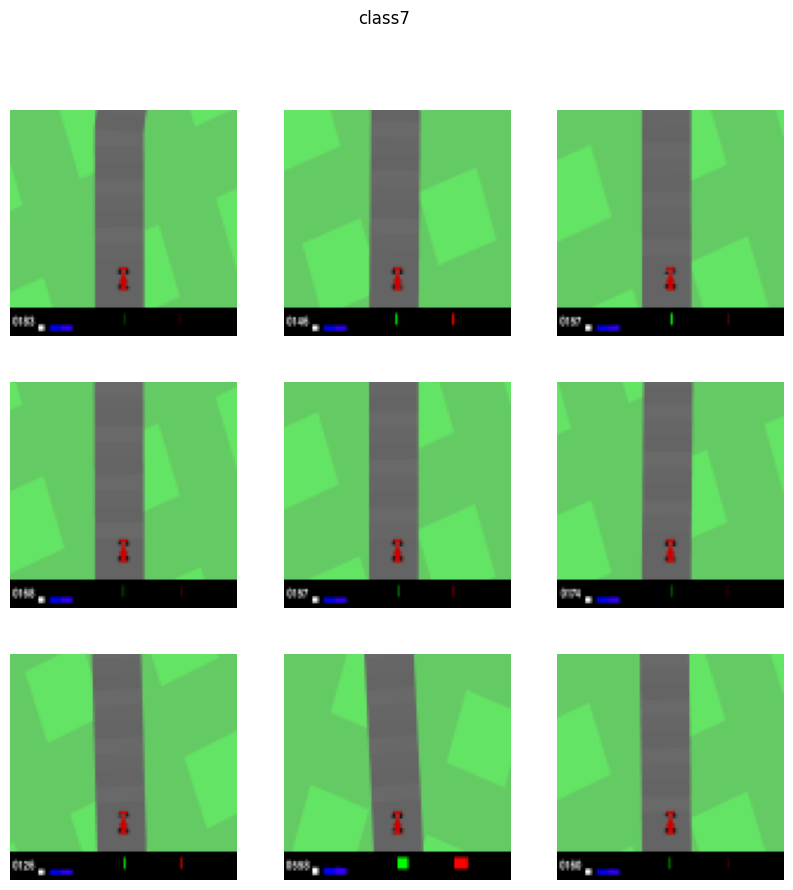

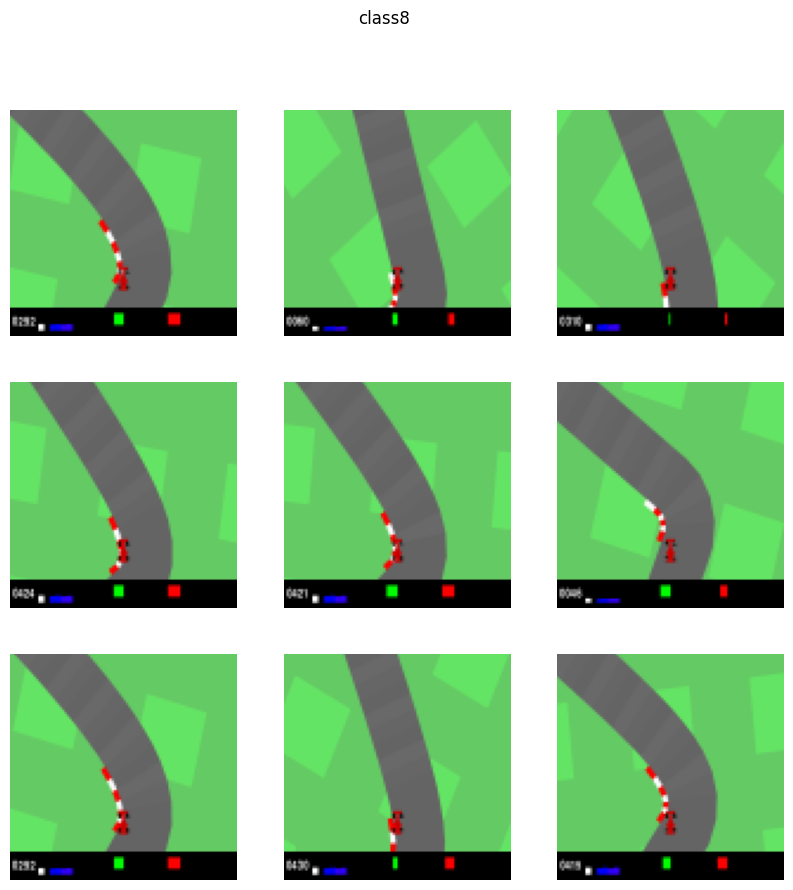

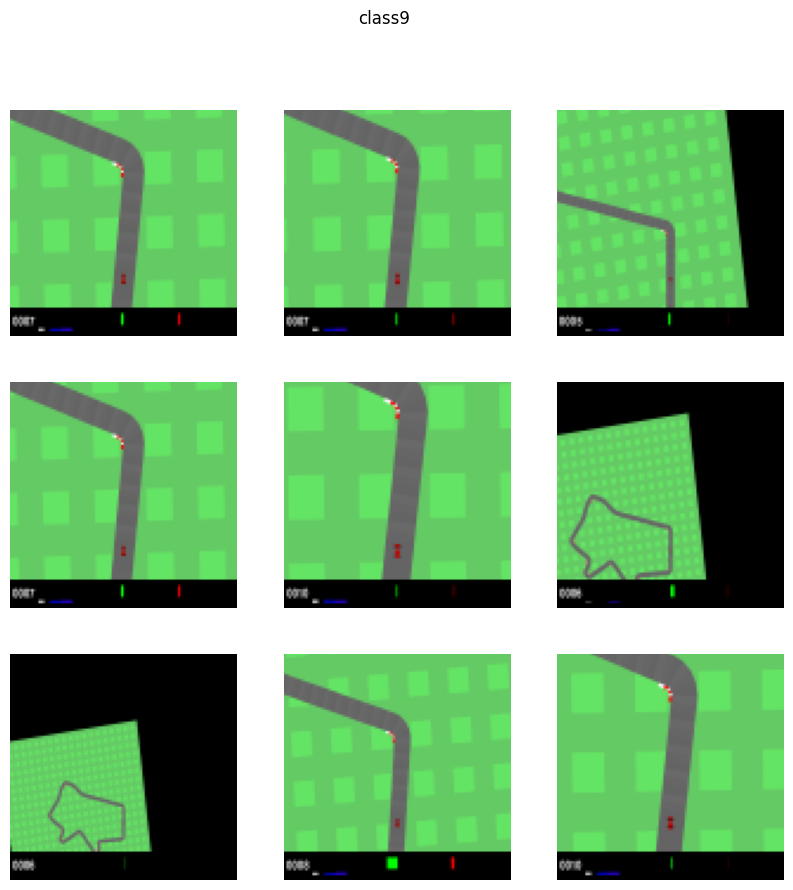

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

# クラスごとに画像を表示して保存

for i in range(12):
    indexes = np.where(kmeans.labels_==i)[0]
    if len(indexes) < 9:
        choice_index = indexes
    else:
        choice_index = np.random.choice(indexes, 9)
    plt.figure(figsize=(10, 10))
    for j in range(9):
        if len(indexes) < j + 1:
            break
        plt.subplot(3, 3, j+1)
        plt.imshow(imgs[choice_index[j]])
        plt.axis('off')
    # タイトル
    plt.suptitle('class' + str(i))
    plt.savefig('./imgs/latent'+str(i)+'.png')
    plt.show()

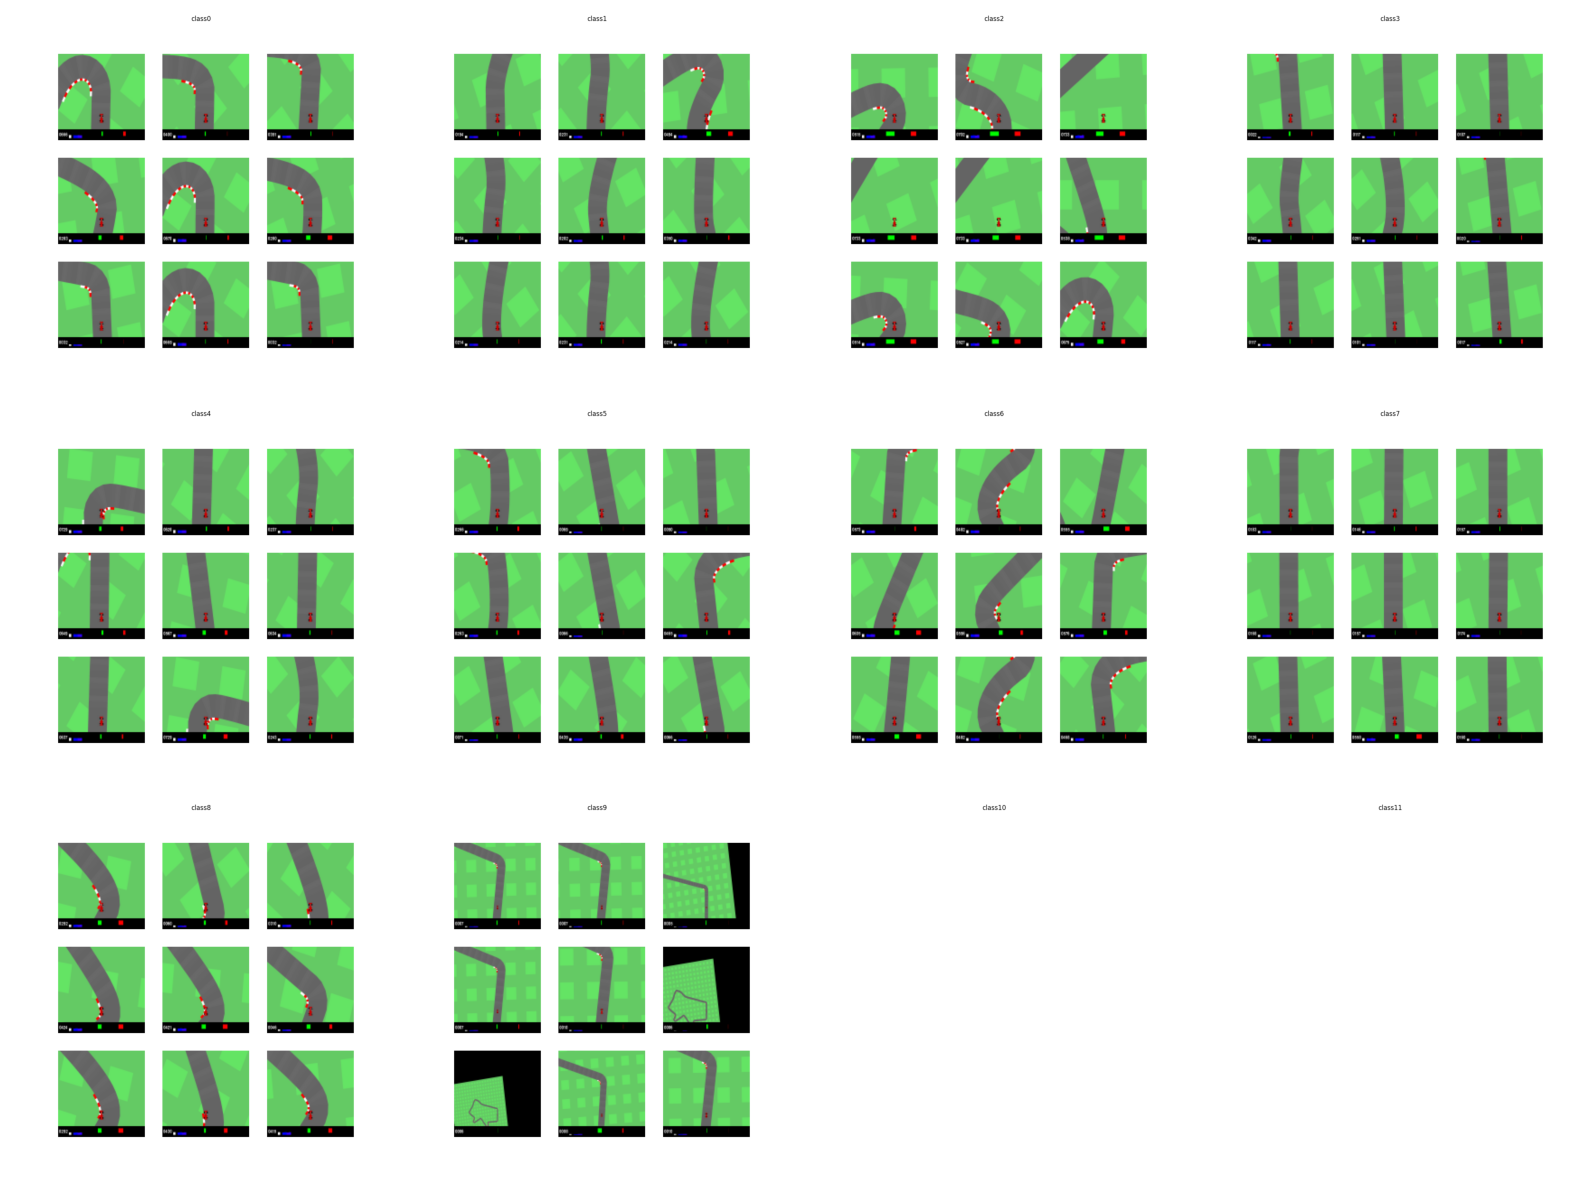

In [11]:
# 画像を1枚にまとめて保存
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
for i in range(12):
    img = plt.imread('./imgs/latent'+str(i)+'.png')
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.savefig('./imgs/latent_all.png')
plt.show()

In [14]:
import imageio

imageio.mimsave('./results/rollout.gif', imgs, duration=20)

In [15]:

while torch.no_grad():
        env = gym.make('CarRacing-v2', render_mode='rgb_array', domain_randomize=False) # 環境：CarRacing-v2
        obs, _ = env.reset() # 環境のリセット
        hidden = [
                torch.zeros(1, RSIZE)#.to(device) # 隠れ状態の初期化
                for _ in range(2)]

        neg_count = 0 # 負の報酬を受け取った回数

        cumulative = 0 # 累積報酬
        i = 0
        
        obs = transform(obs).unsqueeze(0)#.to(device) # 観測（画像）の前処理：obs(1, 3, 64, 64)
        
        action, hidden = get_action_and_transition(obs, hidden) # 行動を起こし、遷移：action(1, ASIZE), hidden(1, RSIZE)
        #Steering: Real valued in [-1, 1] 
        #Gas: Real valued in [0, 1]
        #Break: Real valued in [0, 1]

        obs, reward, done, _, _ = env.step(action) # 行動を実行し、報酬を受け取る：obs(3, 64, 64), reward, done, info
        imgs.append(obs) # 画像の取得
        
        #報酬を得られなかった（コース外に出たなど）連続回数をカウント
        neg_count = neg_count+1 if reward < 0.0 else 0 
        
        #トレーニングのスピードアップのために、コース外の評価を行い，20time step以上コース外に出た場合はロールアウトを終了する
        if (neg_count>20 and early_termination):  
            done = True
        
        cumulative += reward # 累積報酬の更新

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
i = 0
early_termination = True
time_limit = 2000
imgs = []

def get_action_and_transition(obs, hidden):
        """ 行動を起こし、遷移

        VAEを用いて観測値を潜在状態に変換し、MDRNNを用いて次の潜在状態と次の隠れ状態の推定を行い、コントローラに対応するアクションを計算する。

        :args obs: current observation (1 x 3 x 64 x 64) torch tensor
        :args hidden: current hidden state (1 x 256) torch tensor

        :returns: (action, next_hidden)
            - action: 1D np array
            - next_hidden (1 x 256) torch tensor
        """
        latent_mu = dense(obs)
        action = controller(latent_mu, hidden[0] ) # コントローラーによるアクションの計算

        mus, sigmas, logpi, rs, d, next_hidden = mdrnn(action, latent_mu, hidden) # MDRNNによる次の潜在状態と次の隠れ状態の推定

        return action.squeeze().cpu().numpy(), next_hidden


with torch.no_grad():          
    env = gym.make('CarRacing-v2', render_mode='rgb_array', domain_randomize=False) # 環境：CarRacing-v2

    obs, _ = env.reset() # 環境のリセット
    imgs.append(obs) # 画像の取得

    hidden = [
        torch.zeros(1, RSIZE)#.to(device) # 隠れ状態の初期化
        for _ in range(2)]

    neg_count = 0 # 負の報酬を受け取った回数

    cumulative = 0 # 累積報酬
    i = 0
    while True:
        obs = transform(obs).unsqueeze(0)#.to(device) # 観測（画像）の前処理：obs(1, 3, 64, 64)
        
        action, hidden = get_action_and_transition(obs, hidden) # 行動を起こし、遷移：action(1, ASIZE), hidden(1, RSIZE)
        #Steering: Real valued in [-1, 1] 
        #Gas: Real valued in [0, 1]
        #Break: Real valued in [0, 1]

        obs, reward, done, _, _ = env.step(action) # 行動を実行し、報酬を受け取る：obs(3, 64, 64), reward, done, info
        imgs.append(obs) # 画像の取得
        
        #報酬を得られなかった（コース外に出たなど）連続回数をカウント
        neg_count = neg_count+1 if reward < 0.0 else 0 
        
        #トレーニングのスピードアップのために、コース外の評価を行い，20time step以上コース外に出た場合はロールアウトを終了する
        if (neg_count>20 and early_termination):  
            done = True
        
        cumulative += reward # 累積報酬の更新
        
        # ロールアウトの終了：タイムリミットに達した場合、早期終了した場合, 完了した場合
        if done or (early_termination and i > time_limit):
            env.close()
            break

        i += 1

imgs = np.array(imgs)